Source of inspiration for this model: https://www.kaggle.com/code/imsparsh/gtzan-genre-classification-deep-learning-val-92-4/notebook

In [1]:
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import matplotlib as plt
import librosa
import os
import subprocess
import csv
from sklearn import metrics, model_selection, preprocessing

Define paths for this model

In [2]:
absolute_path = "f:\\AI Projects\\Music Classification"
relative_path = "Data\\GTZAN\\genres"
full_path = os.path.join(absolute_path, relative_path)

f:\AI Projects\Music Classification\Data\GTZAN\genres


List all music genres contained in this dataset

In [3]:
generes_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

In [4]:
len(generes_list)

10

Read in the metadata

In [5]:
GTZAN_path = os.path.join(absolute_path,"Data\\GTZAN\genres")
file_path = os.path.join(GTZAN_path,"metadata.csv")
metadata = pd.read_csv(file_path)
metadata.head()

,filename,length,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav-0,4.535147,0.340607,0.122398,1773.076114,1955.868447,3688.494873,0.086391,123.046875,-120.494301,...,9.283965,-5.682326,6.937242,-8.601155,-2.293055,-3.826715,1.019838,-2.412001,2.953042,blues
1,blues.00000.wav-1,4.535147,0.339364,0.127939,1803.120119,2080.744242,3999.078369,0.074787,123.046875,-129.895981,...,9.417705,-4.340737,7.461563,-2.396798,5.010379,-2.351950,0.144454,-3.089383,1.655918,blues
2,blues.00000.wav-2,4.535147,0.353243,0.133503,1696.046590,2005.172557,3666.302490,0.071120,123.046875,-112.161453,...,12.625378,-5.172403,7.630077,-9.772185,-0.666326,-2.126123,1.459213,-3.145484,2.411724,blues
3,blues.00000.wav-3,4.535147,0.363599,0.136399,1838.935722,2056.596597,4000.726318,0.083897,129.199219,-104.236809,...,10.776512,-3.352736,5.841449,-6.146827,1.855989,-1.923221,-0.356437,-3.449448,2.081537,blues
4,blues.00000.wav-4,4.535147,0.371211,0.128614,1860.273385,2067.494800,4014.349365,0.084191,123.046875,-107.887718,...,11.879320,-7.173142,6.693336,-5.317769,5.295383,-2.547254,0.429121,-2.686537,1.922374,blues


Use all 100 samples for training data

Hand picked songs for test data
E.g Livin on a prayer
Don't stop believin
Master of puppets
Smells like teens spirit
As it was
All too well
Beethoven symphony 9


In [6]:
print(list(metadata.columns[metadata.isnull().any()]))

[]


No NA or null values in the metadata

Add labels to each file 

In [7]:
label_index = dict()
index_label = dict()

for i, x in enumerate(metadata.label.unique()):
    label_index[x] = i
    index_label[i] = x

metadata.label = [label_index[l] for l in metadata.label]
metadata.head()

,filename,length,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav-0,4.535147,0.340607,0.122398,1773.076114,1955.868447,3688.494873,0.086391,123.046875,-120.494301,...,9.283965,-5.682326,6.937242,-8.601155,-2.293055,-3.826715,1.019838,-2.412001,2.953042,0
1,blues.00000.wav-1,4.535147,0.339364,0.127939,1803.120119,2080.744242,3999.078369,0.074787,123.046875,-129.895981,...,9.417705,-4.340737,7.461563,-2.396798,5.010379,-2.351950,0.144454,-3.089383,1.655918,0
2,blues.00000.wav-2,4.535147,0.353243,0.133503,1696.046590,2005.172557,3666.302490,0.071120,123.046875,-112.161453,...,12.625378,-5.172403,7.630077,-9.772185,-0.666326,-2.126123,1.459213,-3.145484,2.411724,0
3,blues.00000.wav-3,4.535147,0.363599,0.136399,1838.935722,2056.596597,4000.726318,0.083897,129.199219,-104.236809,...,10.776512,-3.352736,5.841449,-6.146827,1.855989,-1.923221,-0.356437,-3.449448,2.081537,0
4,blues.00000.wav-4,4.535147,0.371211,0.128614,1860.273385,2067.494800,4014.349365,0.084191,123.046875,-107.887718,...,11.879320,-7.173142,6.693336,-5.317769,5.295383,-2.547254,0.429121,-2.686537,1.922374,0


Shuffle the dataset

In [8]:
seed = 12
np.random.seed(seed)
df_shuffle = metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
df_shuffle.drop(['filename','length'],axis=1,inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

In [9]:
X_train, df_test_valid_X, y_train, df_test_valid_y = model_selection.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)

X_dev, X_test, y_dev, y_test = model_selection.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

Scale the features

In [10]:
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [11]:
dropout_rate = 0.3

model = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(10, activation='softmax'),
])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              28672     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [12]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [13]:
epoch = 500
batch_size = 128

history = model.fit(X_train,y_train,validation_data=(X_dev,y_dev),epochs=epoch,batch_size=batch_size)

Epoch 1/500
33/33 [==============================] - 2s 14ms/step - loss: 1.8919 - accuracy: 0.3188 - val_loss: 1.4223 - val_accuracy: 0.4621
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 1.5480 - accuracy: 0.4510 - val_loss: 1.2463 - val_accuracy: 0.5471
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 1.3744 - accuracy: 0.5224 - val_loss: 1.1610 - val_accuracy: 0.5859
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 1.2544 - accuracy: 0.5788 - val_loss: 1.0721 - val_accuracy: 0.6507
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 1.1240 - accuracy: 0.6188 - val_loss: 1.0229 - val_accuracy: 0.6616
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 1.0474 - accuracy: 0.6476 - val_loss: 0.9412 - val_accuracy: 0.6768
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.9728 - accuracy: 0.6733 - val_loss: 0.9154 - val_accuracy: 0.6953
Epoch 8/500


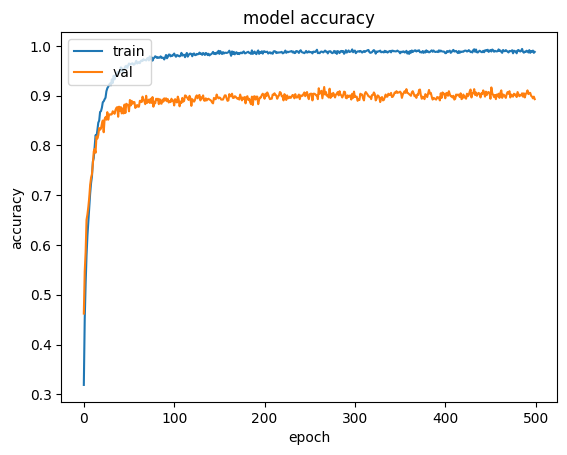

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

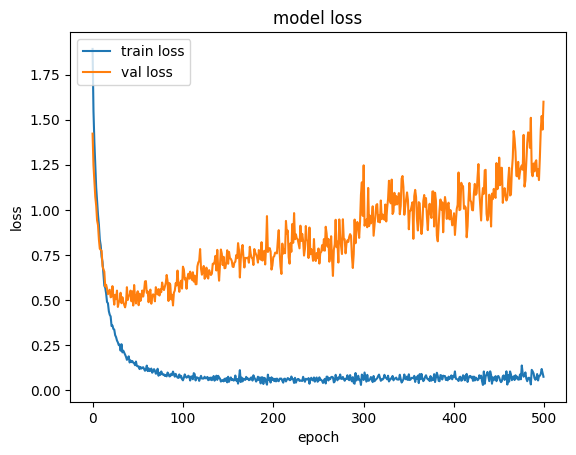

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','val loss'], loc='upper left')
plt.show()

In [16]:
loss, accuracy = model.evaluate(X_test,y_test,batch_size=batch_size)

print(f"Loss: {round(loss,4)}")
print(f"Accuracy: {round(accuracy * 100,2)}%")

5/5 [==============================] - 0s 3ms/step - loss: 1.9584 - accuracy: 0.8627
Loss: 1.9584
Accuracy: 86.27%


Evaluation accuracy currently sitting between **85%** to **90%**

### Predict using the GTZAN samples

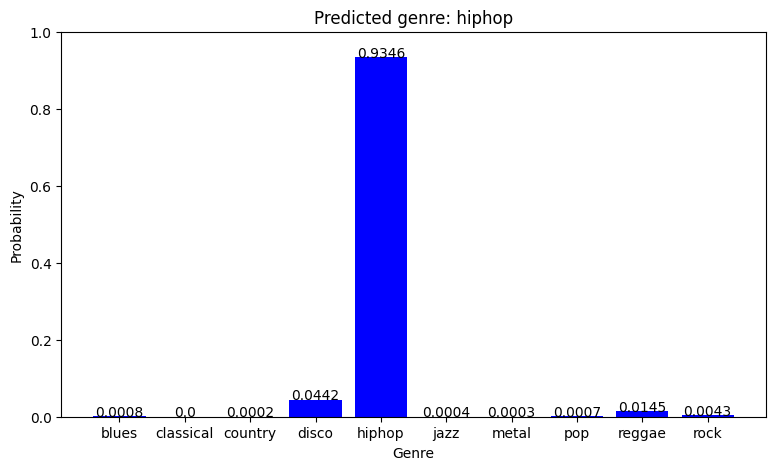

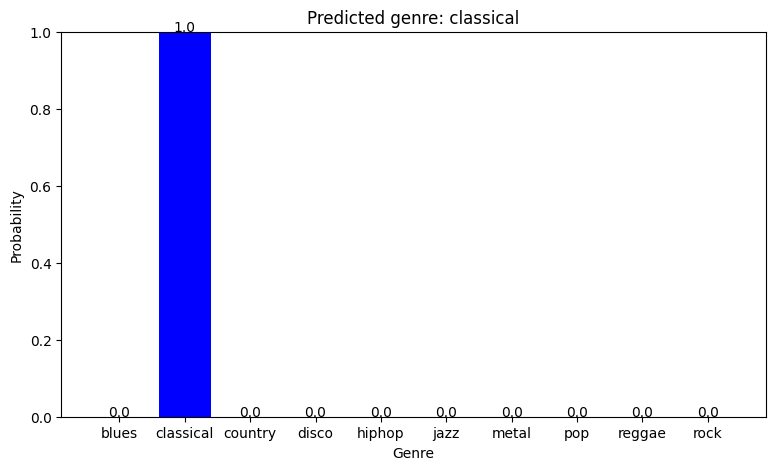

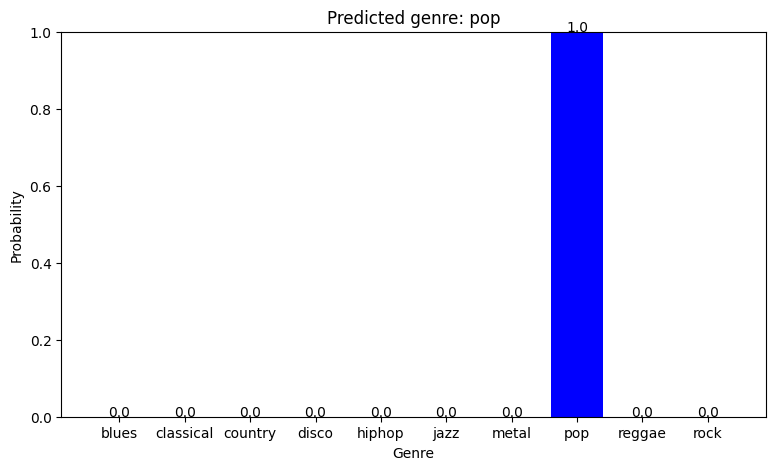

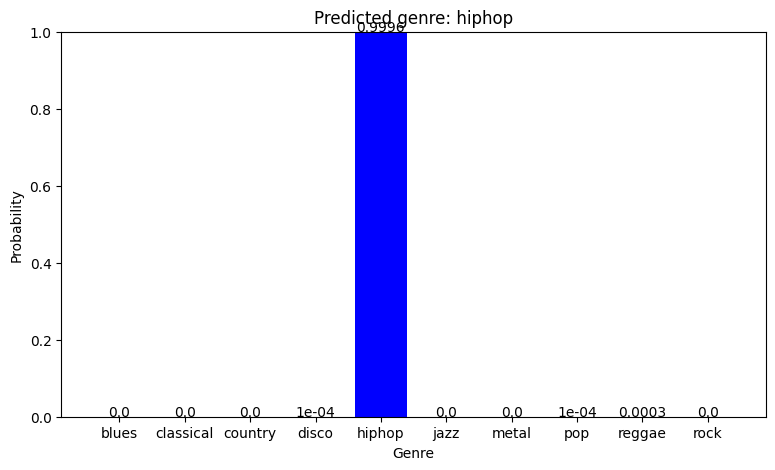

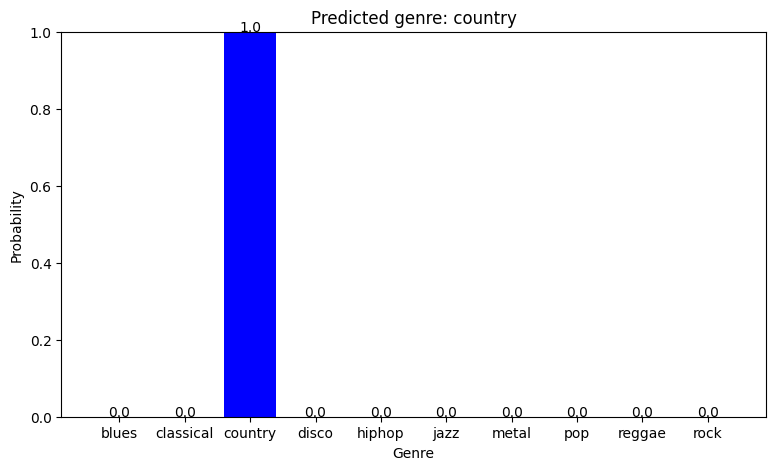

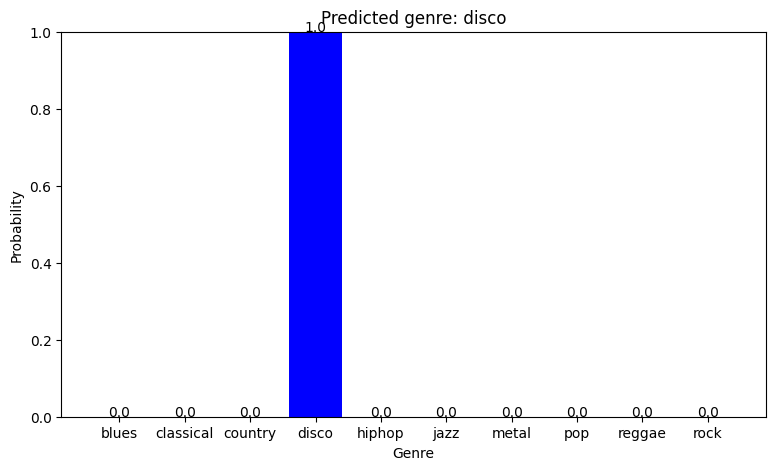

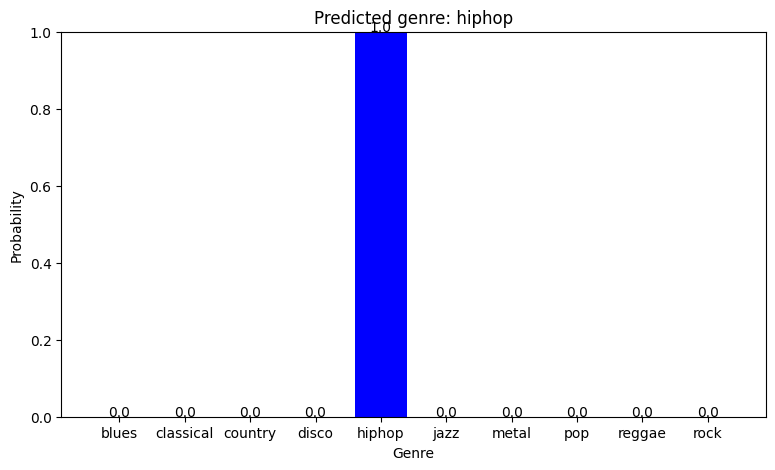

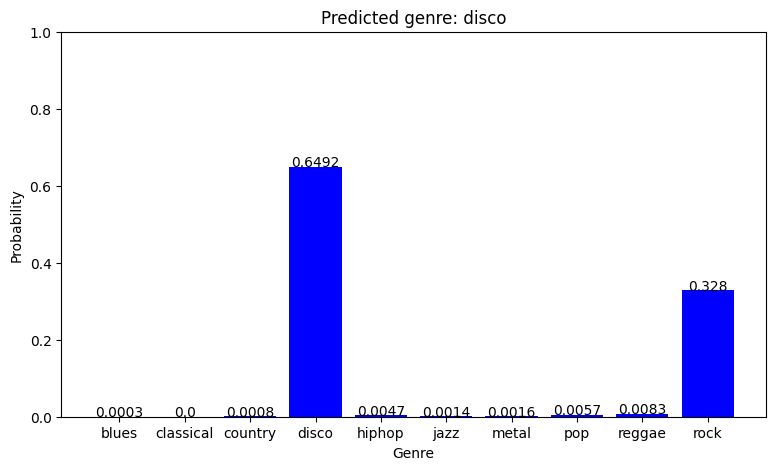

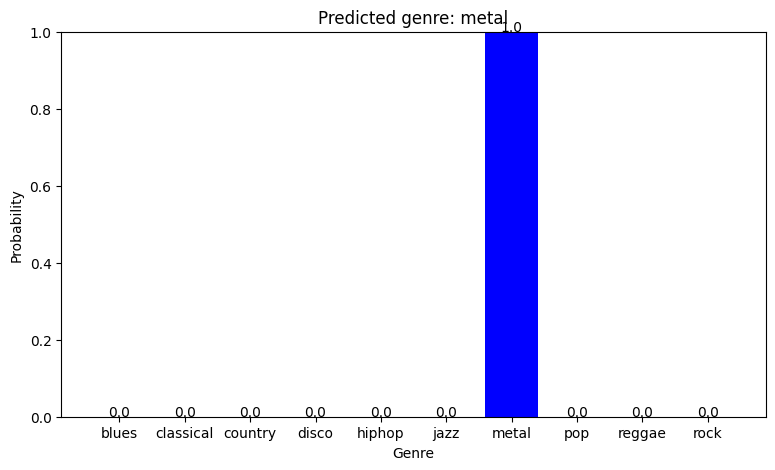

In [17]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

for i in range(1,10):
    sample = X_test.sample()
    prediction = model.predict(sample)
    plt.figure(figsize= (20,5))
    plt.subplot(1, 2, 1)
    plt.grid(False)

    x = range(len(generes_list))
    y = np.round(prediction[0],4)
    plt.xticks(range(0,len(generes_list)), generes_list)
    plt.bar(x, y, color="#0000FF")
    plt.ylim([0, 1])
    predicted_genre = index_label[np.argmax(prediction[0])]
    plt.title(f'Predicted genre: {predicted_genre}')
    plt.xlabel("Genre")
    plt.ylabel("Probability")
    addlabels(x,y)
    plt.show()
